In [47]:
from pathlib import Path

import pandas as pd
import regex as re
from IPython.core.display_functions import display

In [48]:
data_dir = "./exp-local/data"


def import_data(dir):
    all_files = Path(dir).glob('data*.txt')
    all_data = [pd.read_fwf(path, skiprows=[1], index_col=None) for path in all_files]
    return pd.concat(all_data, axis=0, ignore_index=True)


data = import_data(data_dir)
data

,JobID,JobName,Cluster,Unnamed: 3,NodeList,State,Start,End,ConsumedEnergy,AveRSS,...,UID,User,WCKey,WCKeyID,WorkDir,Submit,Unnamed: 112,Unnamed: 113,Unnamed: 114,SubmitLine
0,48897,dpp-local-nc4_gl6-35.cfg,gl2_gl4,NaN,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,NaN,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:56,sbatch --job-name=dpp-local-nc4_gl6-35.cfg -w,gl6 -n 4 --dependency=afterany:48896 --wrap=(p...,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.dpp-local-nc4_gl6-35.cfg.info/haddock.ou...
1,48897.batch,batch,gl2_gl4,NaN,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516.68K,701608K,...,NaN,NaN,NaN,NaN,NaN,2024-01-15T15:44:01,NaN,NaN,NaN,NaN
2,48900,daa-local-nc4_gl6-33.cfg,gl2_gl4,NaN,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,NaN,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:56,sbatch --job-name=daa-local-nc4_gl6-33.cfg -w,gl6 -n 4 --dependency=afterany:48899 --wrap=(p...,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.daa-local-nc4_gl6-33.cfg.info/haddock.ou...
3,48900.batch,batch,gl2_gl4,NaN,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7.59M,1483588K,...,NaN,NaN,NaN,NaN,NaN,2024-01-15T17:01:54,NaN,NaN,NaN,NaN
4,48903,daa-local-nc4_gl6-32.cfg,gl2_gl4,NaN,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,NaN,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:56,sbatch --job-name=daa-local-nc4_gl6-32.cfg -w,gl6 -n 4 --dependency=afterany:48902 --wrap=(p...,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.daa-local-nc4_gl6-32.cfg.info/haddock.ou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,49182,daa-local-nc2_gl6-35.cfg,gl2_gl4,None,assigned,CANCELLED+,None,2024-01-17T15:42:49,0,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,sbatch --job-name=daa-local-nc2_gl6-35.cfg -w,gl6 -n 2 --dependency=afterany:49181 --wrap=(p...,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.daa-local-nc2_gl6-35.cfg.info/haddock.ou...
114,49185,daa-local-nc16_gl6-32.cfg,gl2_gl4,None,assigned,PENDING,Unknown,Unknown,0,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,sbatch --job-name=daa-local-nc16_gl6-32.cfg -w...,-n 16 --dependency=afterany:49184 --wrap=(perf...,"power/energy-pkg/,power/energy-ram/ haddock3 '...",run.daa-local-nc16_gl6-32.cfg.info/haddock.out...
115,49188,daa-local-nc4_gl6-37.cfg,gl2_gl4,None,assigned,PENDING,Unknown,Unknown,0,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,sbatch --job-name=daa-local-nc4_gl6-37.cfg -w,gl6 -n 4 --dependency=afterany:49187 --wrap=(p...,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.daa-local-nc4_gl6-37.cfg.info/haddock.ou...
116,49191,daa-local-nc2_gl6-37.cfg,gl2_gl4,None,assigned,CANCELLED+,None,2024-01-17T15:42:49,0,NaN,...,1009.0,greenBeans,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,sbatch --job-name=daa-local-nc2_gl6-37.cfg -w,gl6 -n 2 --dependency=afterany:49190 --wrap=(p...,"-e power/energy-pkg/,power/energy-ram/ haddock...",> run.daa-local-nc2_gl6-37.cfg.info/haddock.ou...


In [49]:
def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [50]:
def filter_out_completed_jobs(dat):
    dat = dat[dat.State == 'COMPLETED']
    dat.JobName = dat.JobName.replace('batch', method='ffill')
    return dat.dropna(subset=['ConsumedEnergy'])


def extract_params_from_local_file_name(dat):
    dat[['Workflow', 'mode', 'ncores', 'node', 'trial']] = dat.JobName.str.extract(
        r'(\w+)-(\w+)-nc(\d+)_(gl\d+)-(\d+).cfg')
    dat.ncores = dat.ncores.astype(int)
    dat.trial = dat.trial.astype(int)
    return dat


def append_job_data_columns(dat):
    for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
        dat[column] = dat[column].apply(convert_to_numeric)
        dat[f"{column}K"] = dat[column] / 1000
        dat[f"{column}M"] = dat[column] / 1_000_000
        dat[f"{column}G"] = dat[column] / 1_000_000_000
    dat['ElapsedSeconds'] = dat.Elapsed.apply(convert_elapsed_time)
    dat['ElapsedMinutes'] = dat.ElapsedSeconds / 60
    dat['ElapsedHours'] = dat.ElapsedMinutes / 60
    return dat


In [51]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

data_completed = filter_out_completed_jobs(data)
data_completed = data_completed[~data_completed.JobName.str.contains("nc2")].reset_index(drop=True)

data_pending = data[data.State == "PENDING"]
data_pending = data_pending[~data_pending.JobName.str.contains("nc2")].reset_index(drop=True)

data = pd.concat([data_completed, data_pending], axis=0, ignore_index=True)
data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)

# data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)
data = extract_params_from_local_file_name(data)
data_completed = extract_params_from_local_file_name(data_completed)
data_pending = extract_params_from_local_file_name(data_pending)

data_completed = append_job_data_columns(data_completed)
data_completed = data_completed.sort_values(by=['ncores', 'Workflow'])

display(data_completed, data_pending, data)

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_34788\3033834533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.JobName = dat.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskReadG,AveDiskWriteK,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours
1,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7590000.0,1.483588e+09,8.835671e+10,...,88.35671,12752490.0,12752.49,12.75249,27547708.0,27547.708,27.547708,62144,1035.733333,17.262222
2,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7580000.0,1.460128e+09,8.837871e+10,...,88.37871,12753280.0,12753.28,12.75328,27544800.0,27544.800,27.544800,62286,1038.100000,17.301667
0,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516680.0,7.016080e+08,5.343470e+09,...,5.34347,805040.0,805.04,0.80504,26546972.0,26546.972,26.546972,4369,72.816667,1.213611
6,48927.batch,daa-local-nc8_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T15:58:01,2024-01-18T01:50:16,4760000.0,2.628628e+09,8.837871e+10,...,88.37871,12752480.0,12752.48,12.75248,52596560.0,52596.560,52.596560,35535,592.250000,9.870833
10,48939.batch,daa-local-nc8_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T03:24:58,2024-01-18T13:17:09,4750000.0,3.356084e+09,8.837870e+10,...,88.37870,12752540.0,12752.54,12.75254,52589456.0,52589.456,52.589456,35531,592.183333,9.869722
3,48909.batch,dpp-local-nc8_gl6-34.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T06:08:31,2024-01-17T06:49:57,323520.0,1.200996e+09,5.341970e+09,...,5.34197,804920.0,804.92,0.80492,50582916.0,50582.916,50.582916,2486,41.433333,0.690556
5,48915.batch,dpp-local-nc16_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T07:21:09,2024-01-17T07:47:50,229280.0,2.223508e+09,5.342780e+09,...,5.34278,805050.0,805.05,0.80505,98676764.0,98676.764,98.676764,1601,26.683333,0.444722
8,48933.batch,dpp-local-nc16_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T02:21:50,2024-01-18T02:48:16,230060.0,2.207268e+09,5.345290e+09,...,5.34529,805130.0,805.13,0.80513,98670388.0,98670.388,98.670388,1586,26.433333,0.440556
9,48936.batch,dpp-local-nc16_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T02:53:18,2024-01-18T03:19:57,231150.0,2.220572e+09,5.341970e+09,...,5.34197,804930.0,804.93,0.80493,98728264.0,98728.264,98.728264,1599,26.650000,0.444167
11,48942.batch,dpp-local-nc16_gl6-36.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T13:22:11,2024-01-18T13:48:41,230180.0,2.220024e+09,5.345290e+09,...,5.34529,805130.0,805.13,0.80513,98661868.0,98661.868,98.661868,1590,26.500000,0.441667


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,WCKey,WCKeyID,WorkDir,Submit,SubmitLine,Workflow,mode,ncores,node,trial
0,48957,daa-local-nc16_gl6-34.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:57,run.daa-local-nc16_gl6-34.cfg.info/haddock.out...,daa,local,16,gl6,34
1,48960,dpp-local-nc8_gl6-31.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:57,> run.dpp-local-nc8_gl6-31.cfg.info/haddock.ou...,dpp,local,8,gl6,31
2,48966,daa-local-nc32_gl6-40.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:57,run.daa-local-nc32_gl6-40.cfg.info/haddock.out...,daa,local,32,gl6,40
3,48969,dpp-local-nc32_gl6-38.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:57,run.dpp-local-nc32_gl6-38.cfg.info/haddock.out...,dpp,local,32,gl6,38
4,48972,daa-local-nc4_gl6-40.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:12:57,> run.daa-local-nc4_gl6-40.cfg.info/haddock.ou...,daa,local,4,gl6,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,49176,daa-local-nc8_gl6-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc8_gl6-33.cfg.info/haddock.ou...,daa,local,8,gl6,33
60,49179,daa-local-nc4_gl6-31.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc4_gl6-31.cfg.info/haddock.ou...,daa,local,4,gl6,31
61,49185,daa-local-nc16_gl6-32.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,run.daa-local-nc16_gl6-32.cfg.info/haddock.out...,daa,local,16,gl6,32
62,49188,daa-local-nc4_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc4_gl6-37.cfg.info/haddock.ou...,daa,local,4,gl6,37


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,WCKey,WCKeyID,WorkDir,Submit,SubmitLine,Workflow,mode,ncores,node,trial
0,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516.68K,701608K,5343.47M,...,NaN,NaN,NaN,2024-01-15T15:44:01,NaN,dpp,local,4,gl6,35
1,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7.59M,1483588K,88356.71M,...,NaN,NaN,NaN,2024-01-15T17:01:54,NaN,daa,local,4,gl6,33
2,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7.58M,1460128K,88378.71M,...,NaN,NaN,NaN,2024-01-16T10:22:42,NaN,daa,local,4,gl6,32
3,48909.batch,dpp-local-nc8_gl6-34.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T06:08:31,2024-01-17T06:49:57,323.52K,1200996K,5341.97M,...,NaN,NaN,NaN,2024-01-17T06:08:31,NaN,dpp,local,8,gl6,34
4,48912.batch,dpp-local-nc32_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T06:55:02,2024-01-17T07:16:05,197.42K,3915788K,5342.08M,...,NaN,NaN,NaN,2024-01-17T06:55:02,NaN,dpp,local,32,gl6,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,49176,daa-local-nc8_gl6-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc8_gl6-33.cfg.info/haddock.ou...,daa,local,8,gl6,33
74,49179,daa-local-nc4_gl6-31.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc4_gl6-31.cfg.info/haddock.ou...,daa,local,4,gl6,31
75,49185,daa-local-nc16_gl6-32.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,run.daa-local-nc16_gl6-32.cfg.info/haddock.out...,daa,local,16,gl6,32
76,49188,daa-local-nc4_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,NaN,0.0,/mnt/nfs_share/greenBeansHaddock/exp-local,2024-01-15T15:13:00,> run.daa-local-nc4_gl6-37.cfg.info/haddock.ou...,daa,local,4,gl6,37


In [52]:
data = data.dropna(subset=['AveCPU'])

data['n_ave_cpu'] = data['AveCPU'].apply(convert_elapsed_time)
data['n_elapsed'] = data['Elapsed'].apply(convert_elapsed_time)
data['cpu_utilization'] = data['n_ave_cpu'] / data['n_elapsed']
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,Submit,SubmitLine,Workflow,mode,ncores,node,trial,n_ave_cpu,n_elapsed,cpu_utilization
0,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516.68K,701608K,5343.47M,...,2024-01-15T15:44:01,NaN,dpp,local,4,gl6,35,15518,4369,3.551843
1,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7.59M,1483588K,88356.71M,...,2024-01-15T17:01:54,NaN,daa,local,4,gl6,33,226749,62144,3.648767
2,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7.58M,1460128K,88378.71M,...,2024-01-16T10:22:42,NaN,daa,local,4,gl6,32,226560,62286,3.637415
3,48909.batch,dpp-local-nc8_gl6-34.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T06:08:31,2024-01-17T06:49:57,323.52K,1200996K,5341.97M,...,2024-01-17T06:08:31,NaN,dpp,local,8,gl6,34,16936,2486,6.812550
4,48912.batch,dpp-local-nc32_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T06:55:02,2024-01-17T07:16:05,197.42K,3915788K,5342.08M,...,2024-01-17T06:55:02,NaN,dpp,local,32,gl6,33,28679,1263,22.707047
5,48915.batch,dpp-local-nc16_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T07:21:09,2024-01-17T07:47:50,229.28K,2223508K,5342.78M,...,2024-01-17T07:21:09,NaN,dpp,local,16,gl6,40,19987,1601,12.484072
6,48927.batch,daa-local-nc8_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T15:58:01,2024-01-18T01:50:16,4.76M,2628628K,88378.71M,...,2024-01-17T15:58:01,NaN,daa,local,8,gl6,32,253848,35535,7.143605
7,48930.batch,dpp-local-nc32_gl6-37.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T01:55:20,2024-01-18T02:16:45,200.24K,3919372K,5343.48M,...,2024-01-18T01:55:20,NaN,dpp,local,32,gl6,37,28531,1285,22.203113
8,48933.batch,dpp-local-nc16_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T02:21:50,2024-01-18T02:48:16,230.06K,2207268K,5345.29M,...,2024-01-18T02:21:50,NaN,dpp,local,16,gl6,35,19964,1586,12.587642
9,48936.batch,dpp-local-nc16_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T02:53:18,2024-01-18T03:19:57,231.15K,2220572K,5341.97M,...,2024-01-18T02:53:18,NaN,dpp,local,16,gl6,32,19976,1599,12.492808


In [53]:
jobs_to_eliminate = data[data.ncores == 2]
" ".join(map(str, list(jobs_to_eliminate.JobID.to_list())))

''

In [99]:
collected_data_stats = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).describe().reset_index()
collected_data_stats.to_csv(
    'new.local_exp_overview_stats.csv', header=True)
collected_data_stats

Workflow   mode ncores node ConsumedEnergy                             \
                                       count          mean          std   
0      daa  local      4  gl6            2.0  7.585000e+06  7071.067812   
1      daa  local      8  gl6            2.0  4.755000e+06  7071.067812   
2      dpp  local      4  gl6            1.0  5.166800e+05          NaN   
3      dpp  local      8  gl6            1.0  3.235200e+05          NaN   
4      dpp  local     16  gl6            5.0  2.303360e+05   763.629491   
5      dpp  local     32  gl6            3.0  1.985033e+05  1519.287114   

                                    ... ElapsedHours             \
         min        25%        50%  ...          75%        max   
0  7580000.0  7582500.0  7585000.0  ...    17.291806  17.301667   
1  4750000.0  4752500.0  4755000.0  ...     9.870556   9.870833   
2   516680.0   516680.0   516680.0  ...     1.213611   1.213611   
3   323520.0   323520.0   323520.0  ...     0.690556   0.690556   
4   229280.0   230060.0   230180.0  ...     0.444722   0.446944   
5   197420.0   197635.0   197850.0  ...     0.354028   0.356944   

  n_trials_completed                                     
               count mean  std  min  25%  50%  75%  max  
0                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  
1                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  
2                1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0  
3                1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0  
4                5.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0  
5                3.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0  

[6 rows x 508 columns]

In [100]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    n_trials=('trial', 'count'), trials_list=('trial', lambda x: sorted(x.tolist()))).reset_index()
collected_data.to_csv('new.local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,node,n_trials,trials_list
0,daa,local,4,gl6,2,"[32, 33]"
1,daa,local,8,gl6,2,"[32, 38]"
2,dpp,local,4,gl6,1,[35]
3,dpp,local,8,gl6,1,[34]
4,dpp,local,16,gl6,5,"[32, 33, 35, 36, 40]"
5,dpp,local,32,gl6,3,"[33, 37, 39]"


In [97]:
def to_local_config_class(workflow, node, trial, ncores, warmup=False):
    warmup_arg = ", True" if warmup else ""
    return f'LocalConfig("{workflow}", "{node}", {trial}, {ncores}{warmup_arg})'


def to_configs_array(x, start_idx, node):
    return f'[{to_local_config_class(x.Workflow, node if node else x.node, "trial", x.ncores)} for trial in range({start_idx}, {start_idx} + {x.trials_left_count})]'


def max_ncores(node):
    if node == 'gl2':
        return 8
    return 32


def get_configs_code_for_new_experiment(node, data_of_node, target_total_n, start_idx):
    exp_data = collected_data[(collected_data.node == data_of_node) & (
            collected_data.n_trials < target_total_n)]
    exp_data['trials_left_count'] = target_total_n - exp_data.n_trials
    exp_data['code'] = exp_data.apply(to_configs_array, axis=1, start_idx=start_idx, node=node)
    return " + ".join(exp_data.code.to_list()), to_local_config_class('dpp', node, start_idx,
                                                                      max_ncores(node), warmup=True)

In [98]:
TOTAL_EXPERIMENTS_PER_EPOCH = 10


def get_class_name(node, epoch):
    return f"{node.upper()}_{epoch}"


def generate_class(node, epoch, target_total_n, data_of_node):
    configs, warmup_config = get_configs_code_for_new_experiment(node, data_of_node, target_total_n,
                                                                 (epoch - 1) * TOTAL_EXPERIMENTS_PER_EPOCH + 1)
    class_definition = \
        f"""
from typing import List

from examples.domain import LocalExperiment
from examples.domain.config.Config import Config
from examples.domain.config.LocalConfig import LocalConfig

class {get_class_name(node, epoch)}(LocalExperiment):
    def create_configs(self) -> List[Config]:
        return {configs}

    def create_warmup_config(self) -> Config:
        return {warmup_config}
"""
    return class_definition if configs else None

In [96]:
# new experiment epochs
def generate_experiment_classes(exp_epochs, data_of_node: str):
    for node, epoch in exp_epochs.items():
        class_code = generate_class(node, epoch, TOTAL_EXPERIMENTS_PER_EPOCH, data_of_node)
        if class_code is None:
            continue

        file_path = f"../examples/domain/experiment/local/{get_class_name(node, epoch)}.py"
        with open(file_path, 'w') as file:
            file.write(class_code)


generate_experiment_classes({
    # "gl2": 3,
    # "gl6": 3,
    "gl5": 3
}, data_of_node="gl6")

gl5
gl5
gl5
gl5
gl5
gl5


In [59]:
data_completed['n_trials_completed'] = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).Workflow.transform('count')
data_completed['n_trials_threshold'] = data_completed['n_trials_completed'] >= 2
data_completed

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_trials_completed,n_trials_threshold
1,48900.batch,daa-local-nc4_gl6-33.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T17:01:54,2024-01-16T10:17:38,7590000.0,1.483588e+09,8.835671e+10,...,12752.49,12.75249,27547708.0,27547.708,27.547708,62144,1035.733333,17.262222,2,True
2,48903.batch,daa-local-nc4_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-16T10:22:42,2024-01-17T03:40:48,7580000.0,1.460128e+09,8.837871e+10,...,12753.28,12.75328,27544800.0,27544.800,27.544800,62286,1038.100000,17.301667,2,True
0,48897.batch,dpp-local-nc4_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-15T15:44:01,2024-01-15T16:56:50,516680.0,7.016080e+08,5.343470e+09,...,805.04,0.80504,26546972.0,26546.972,26.546972,4369,72.816667,1.213611,1,False
6,48927.batch,daa-local-nc8_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T15:58:01,2024-01-18T01:50:16,4760000.0,2.628628e+09,8.837871e+10,...,12752.48,12.75248,52596560.0,52596.560,52.596560,35535,592.250000,9.870833,2,True
10,48939.batch,daa-local-nc8_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T03:24:58,2024-01-18T13:17:09,4750000.0,3.356084e+09,8.837870e+10,...,12752.54,12.75254,52589456.0,52589.456,52.589456,35531,592.183333,9.869722,2,True
3,48909.batch,dpp-local-nc8_gl6-34.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T06:08:31,2024-01-17T06:49:57,323520.0,1.200996e+09,5.341970e+09,...,804.92,0.80492,50582916.0,50582.916,50.582916,2486,41.433333,0.690556,1,False
5,48915.batch,dpp-local-nc16_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-17T07:21:09,2024-01-17T07:47:50,229280.0,2.223508e+09,5.342780e+09,...,805.05,0.80505,98676764.0,98676.764,98.676764,1601,26.683333,0.444722,5,True
8,48933.batch,dpp-local-nc16_gl6-35.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T02:21:50,2024-01-18T02:48:16,230060.0,2.207268e+09,5.345290e+09,...,805.13,0.80513,98670388.0,98670.388,98.670388,1586,26.433333,0.440556,5,True
9,48936.batch,dpp-local-nc16_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T02:53:18,2024-01-18T03:19:57,231150.0,2.220572e+09,5.341970e+09,...,804.93,0.80493,98728264.0,98728.264,98.728264,1599,26.650000,0.444167,5,True
11,48942.batch,dpp-local-nc16_gl6-36.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T13:22:11,2024-01-18T13:48:41,230180.0,2.220024e+09,5.345290e+09,...,805.13,0.80513,98661868.0,98661.868,98.661868,1590,26.500000,0.441667,5,True


In [60]:
import matplotlib.pyplot as plt

In [61]:
data_for_analysis = data_completed[data_completed.n_trials_threshold].reset_index(drop=True)

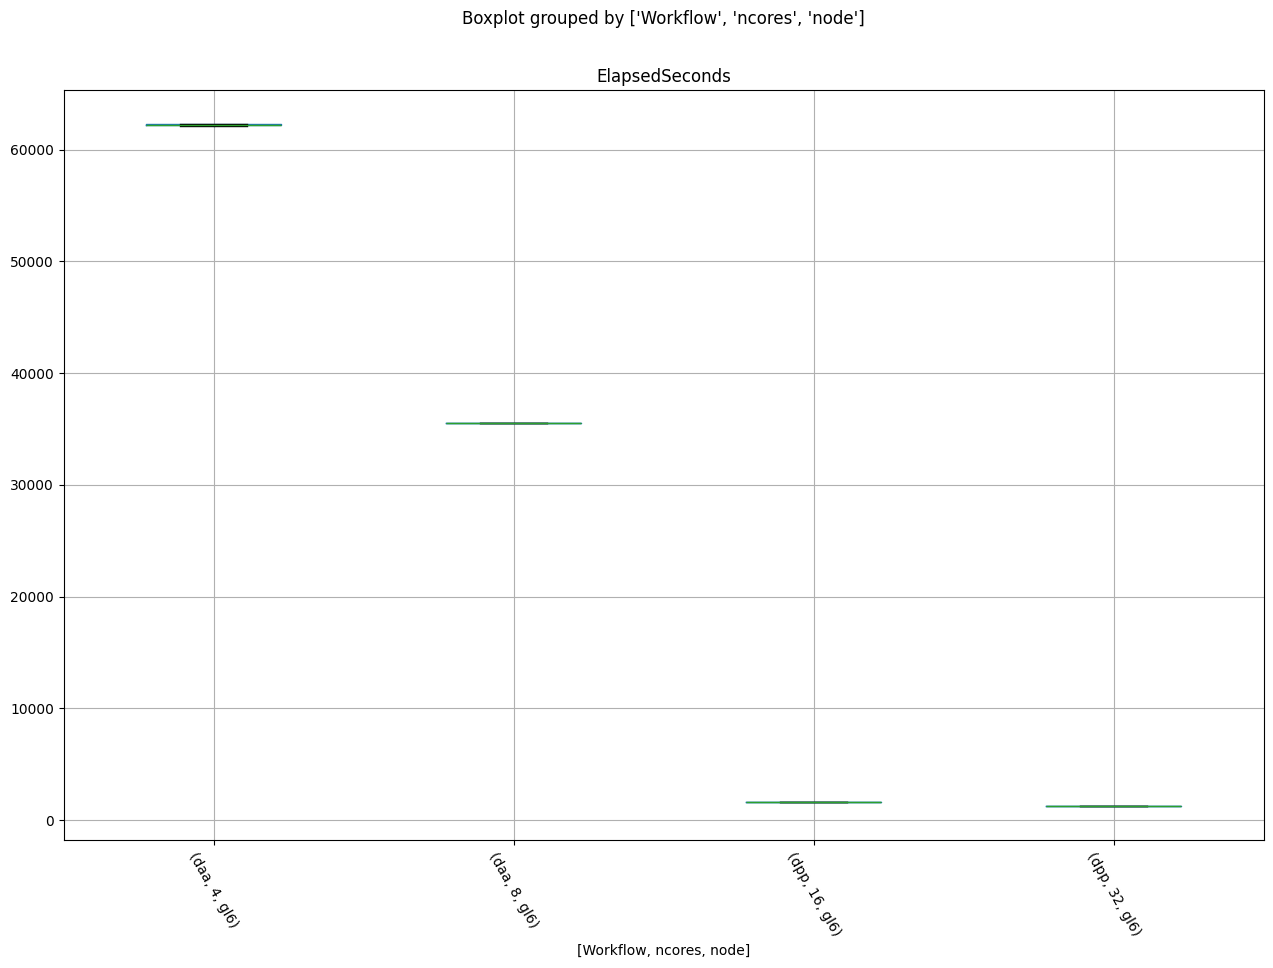

In [62]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data_for_analysis.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-60)
# save
fig.savefig('new.boxplot.png')


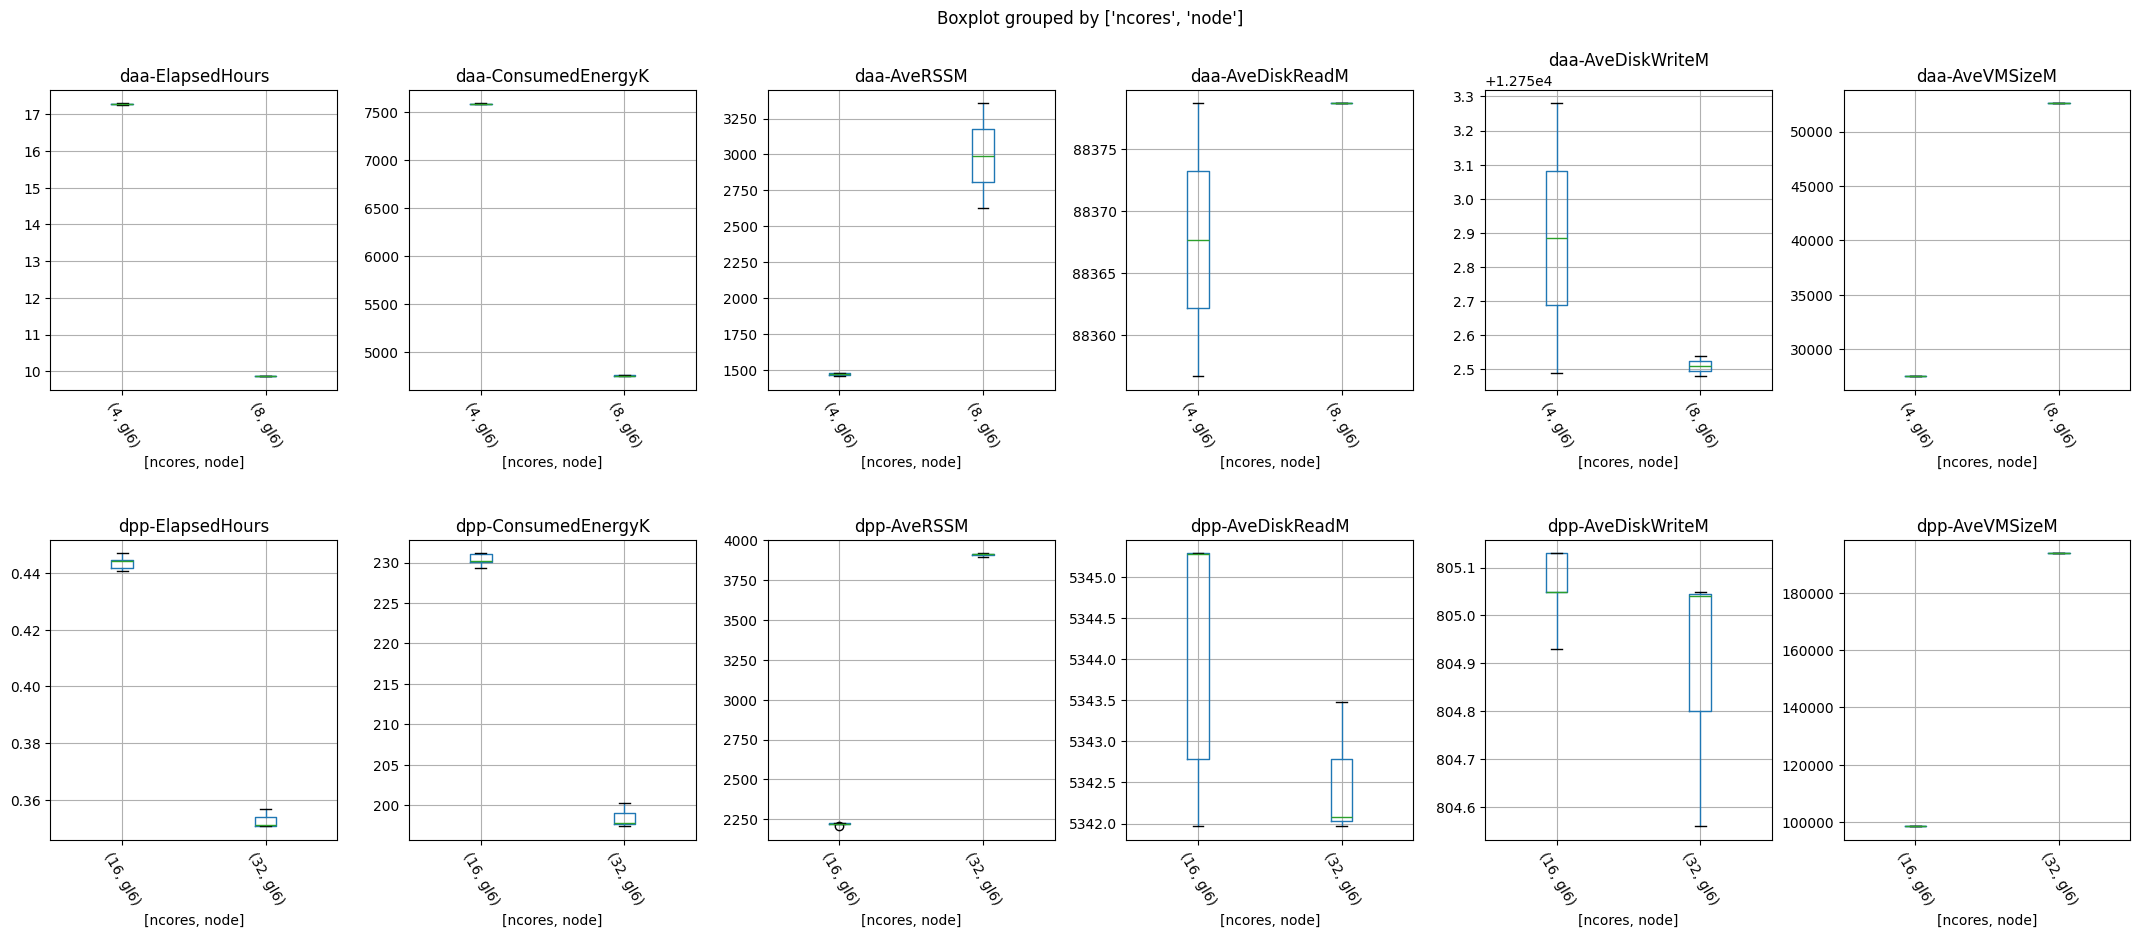

In [63]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
        data_for_analysis[data_for_analysis.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'],
                                                                          ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60)
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('new.boxplot-overview-by-workflows.png')

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(26, 10))
for i, column in enumerate(
        ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
    data_for_analysis.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60)

fig.subplots_adjust(hspace=0.6)

fig.savefig('new.boxplot-overview.png')